In [1]:
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
import sys
import datetime

sys.path.insert(0, '../bifacialvf')
from modelPaper import readpvdaqSNL_CORRECT, simulatepvDAQ

print "Loaded"


Loaded


In [11]:
pvdaq_SNL_Filetitle = "..\\bifacialvf\data\pvdaq_data_1405_2017.csv"
pvDaq_SNL = readpvdaqSNL_CORRECT(pvdaq_SNL_Filetitle, decimate= False, decimatestyle = "Mean" , decimatevalue = 5 )    

timestamps_all = pvDaq_SNL.index
writefiletitle = "..\\bifacialvf\data\Output\SNL_Tracking_output_Jupyter_NEW_Albedo0p33.csv"

name = "[1429] RTC,SNL,Baseline"
lat = 35.0549
lng = -106.5433
elevation = 1658
transmittance = 0.75
dataInterval=1
offset=0
tzstr='US/Mountain'
Cv = 0.5
C = Cv
rtr = 2.0
tracking = True
backtrack = True
albedo = 0.33
tz = -7
rowType = 'single'
transFactor = 0.016
cellRows = 6
beta = 0
sazm = 180
PVfrontSurface = 'glass'
PVbackSurface = 'glass'
gcr = 2.0/7.0

simulatepvDAQ(pvDaq_SNL, writefiletitle,  beta= beta, sazm= sazm, C= Cv, D= None,
         rowType= rowType, transFactor= transFactor, cellRows= cellRows, 
         PVfrontSurface= PVfrontSurface, PVbackSurface= PVbackSurface, albedo= albedo,  
         tracking= tracking, backtrack = backtrack, rtr= rtr, Cv= Cv, offset= offset, 
         lat = lat, lng = lng, tz = tz, name = name, dataInterval= dataInterval)

print " "
print " "
print "FINISHED SIMULATION OF TRACKING!!!"
print " ********************************** "

mat_contents = sio.loadmat('data\SNL_TrackingBifi_SAT_Data.mat')

DateTime_E=mat_contents['DateTime_E']
DateTime_W=mat_contents['DateTime_W']
EETS_Eback=mat_contents['EETS_Eback']
EETS_Efront=mat_contents['EETS_Efront']
EETS_Wback=mat_contents['EETS_Wback']
EETS_Wfront=mat_contents['EETS_Wfront']
TrackerAngle_E=mat_contents['TrackerAngle_E']
TrackerAngle_W=mat_contents['TrackerAngle_W']

import datetime
timestamp_E = []
EETS_Eback_new=[]
EETS_Efront_new=[]
TrackerAngle_E_new=[]
timestamp_W = []
EETS_Wback_new=[]
EETS_Wfront_new=[]
TrackerAngle_W_new=[]


for i in range (0, len(DateTime_E)):
    A=str(DateTime_E[i])
    datehour, minute, second = A.split(':')
    yeartrash, month, dayhour = datehour.split('-')
    day, hour = dayhour.split(' ')
    year = 2017; month = int(month); day = int(day); hour = int(hour); minute = int(minute); second=0
    temptime=datetime.datetime(year, month, day, hour, minute, 0, 0)                
    timestamp_E.append(temptime)
    EETS_Eback_new.append(float(EETS_Eback[i]))
    EETS_Efront_new.append(float(EETS_Efront[i]))
    TrackerAngle_E_new.append(float(TrackerAngle_E[i]))


for i in range (0, len(DateTime_W)):
    A=str(DateTime_W[i])
    datehour, minute, second = A.split(':')
    yeartrash, month, dayhour = datehour.split('-')
    day, hour = dayhour.split(' ')
    year = 2017; month = int(month); day = int(day); hour = int(hour); minute = int(minute); second=0
    temptime=datetime.datetime(year, month, day, hour, minute, 0, 0)                
    timestamp_W.append(temptime)
    EETS_Wback_new.append(float(EETS_Wback[i]))
    EETS_Wfront_new.append(float(EETS_Wfront[i]))
    TrackerAngle_W_new.append(float(TrackerAngle_W[i]))

dataE=pd.DataFrame({'EETS_Eback': EETS_Eback_new, 'EETS_Efront': EETS_Efront_new, 'TrackerAngle_E': TrackerAngle_E_new})
dataW=pd.DataFrame({'EETS_Wback': EETS_Wback_new, 'EETS_Wfront': EETS_Wfront_new, 'TrackerAngle_W': TrackerAngle_W_new})
dataE = pd.DataFrame.from_records(dataE, index=timestamp_E)
dataW = pd.DataFrame.from_records(dataW, index=timestamp_W)

#Load the results from the resultfile
from loadVFresults import loadVFresults
#print data.keys()
(data, metadata) = loadVFresults(writefiletitle)
# calculate average front and back global tilted irradiance across the module chord
data['GTIFrontavg'] = data[['No_1_RowFrontGTI', 'No_2_RowFrontGTI','No_3_RowFrontGTI','No_4_RowFrontGTI','No_5_RowFrontGTI','No_6_RowFrontGTI']].mean(axis=1)
data['GTIBackavg'] = data[['No_1_RowBackGTI', 'No_2_RowBackGTI','No_3_RowBackGTI','No_4_RowBackGTI','No_5_RowBackGTI','No_6_RowBackGTI']].mean(axis=1)
# Print the annual bifacial ratio.
frontIrrSum = data['GTIFrontavg'].sum()
backIrrSum = data['GTIBackavg'].sum()

# Choosing to compare datapoints where both E and W have data, by joining the tables and droping NAs
timestamps_model=[]
GTIFrontavg_new=[]
GTIBackavg_new=[]
for i in range (0, len(data)):
    timestamps_model.append(datetime.datetime(data['Year'][i], data['Month'][i], data['Day'][i], data['Hour'][i], data['Minute'][i], 0, 0))
    GTIFrontavg_new.append(float(data['GTIFrontavg'][i]))
    GTIBackavg_new.append(float(data['GTIBackavg'][i]))

dataModel = pd.DataFrame({'GTIFrontavg': GTIFrontavg_new, 'GTIBackavg': GTIBackavg_new})
dataModel = pd.DataFrame.from_records(dataModel, index=timestamps_model)

resultBoth = dataW.join(dataE, how="outer").join(dataModel, how="outer")
resultBoth=resultBoth.dropna()      

resultBoth['EETS_ERatio']=resultBoth['EETS_Eback']/resultBoth['EETS_Efront']
resultBoth['EETS_WRatio']=resultBoth['EETS_Wback']/resultBoth['EETS_Wfront']
resultBoth['GTIModelRatio']=resultBoth['GTIBackavg']/resultBoth['GTIFrontavg']
GainModel = resultBoth['GTIBackavg'].sum()/resultBoth['GTIFrontavg'].sum()*100
GainE = resultBoth['EETS_Eback'].sum()/resultBoth['EETS_Efront'].sum()*100
GainW = resultBoth['EETS_Wback'].sum()/resultBoth['EETS_Wfront'].sum()*100

plt.figure(figsize=(20,10))
plt.plot(resultBoth['GTIModelRatio'], label='Model, gain '+ str(round(GainModel,2))); plt.plot(resultBoth['EETS_ERatio'], label='EETS_E, gain '+ str(round(GainE,2))); plt.plot(resultBoth['EETS_WRatio'], label='EETS_W, gain '+ str(round(GainW,2))); plt.legend()
plt.show()
print('EAST TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainW))
print('WEST TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainE))
print('MODEL TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainModel))

Reading pvDAQ SNL File:  ..\bifacialvf\data\pvdaq_data_1405_2017.csv
Decimation options:  False
Empty Diffuse at line  420563
Empty Rel. Humidity at line  420563
Empty Wind at line  420563
Empty Temperature at line  420563
 
********* 
Running Simulation for pvDAQ DataFile
Location:   [1429] RTC,SNL,Baseline
Lat:  35.0549  Long:  -106.5433  Tz  -7
Parameters: beta:  0   Sazm:  180   Height:  0.5   rtr separation:  2.0   Row type:  single   Albedo:  0.33
Saving into ..\bifacialvf\data\Output\SNL_Tracking_output_Jupyter_NEW_Albedo0p33.csv
 
 
Distance between rows for no shading on Dec 21 at 9 am solar time =  0.0
Actual distance between rows =  1.0
 
 ***** IMPORTANT --> THIS SIMULATION Has Tracking Activated
Backtracking Option is set to:  True
Finished
 
 
FINISHED SIMULATION OF TRACKING!!!
 ********************************** 


IOError: [Errno 2] No such file or directory: 'data\\SNL_TrackingBifi_SAT_Data.mat'

Reading pvDAQ SNL File:  ..\bifacialvf\data\pvdaq_data_1405_2017.csv
Decimation options:  False
Empty Diffuse at line  420563
Empty Rel. Humidity at line  420563
Empty Wind at line  420563
Empty Temperature at line  420563
 
*************
..\bifacialvf\data\Output\SNL_Tracking_output_Jupyter_NEW_Albedo0p3.csv


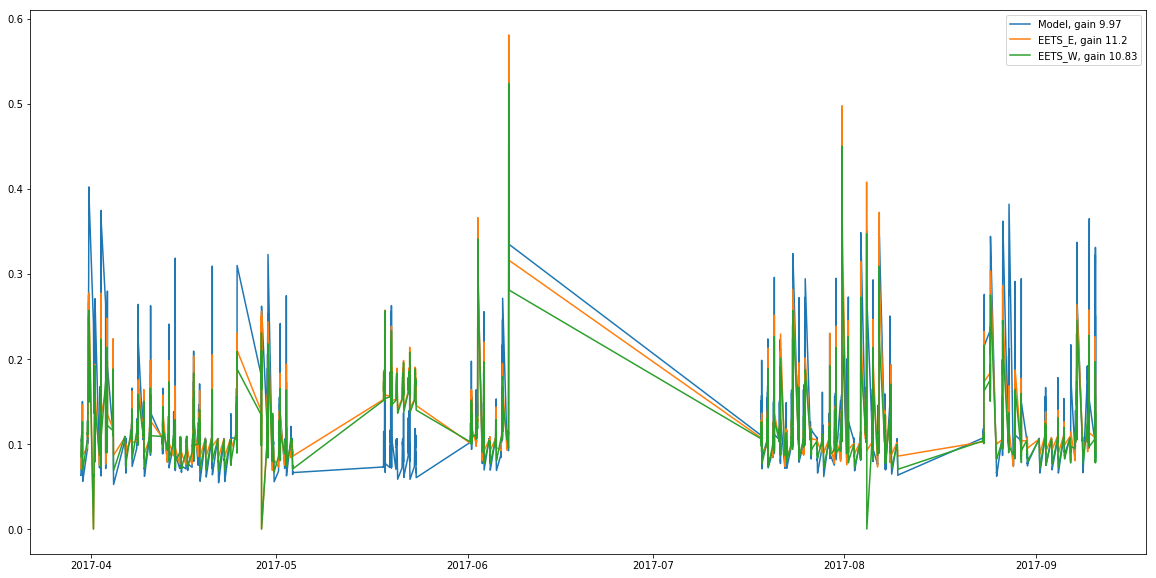

EAST TRACKER: The bifacial ratio for ground clearance 0.5 and rtr spacing 2 is: 10.8%
WEST TRACKER: The bifacial ratio for ground clearance 0.5 and rtr spacing 2 is: 11.2%
MODEL TRACKER: The bifacial ratio for ground clearance 0.5 and rtr spacing 2 is: 10.0%


In [13]:
 # JUST LOADING TO SAVE NEW MAT
    
pvdaq_SNL_Filetitle = "..\\bifacialvf\data\pvdaq_data_1405_2017.csv"
pvDaq_SNL = readpvdaqSNL_CORRECT(pvdaq_SNL_Filetitle, decimate= False, decimatestyle = "Mean" , decimatevalue = 5 )    

timestamps_all = pvDaq_SNL.index
writefiletitle = "..\\bifacialvf\data\Output\SNL_Tracking_output_Jupyter.csv"
writefiletitle = "..\\bifacialvf\data\Output\SNL_Tracking_output_Jupyter_NEW_.csv"
writefiletitle = "..\\bifacialvf\data\Output\SNL_Tracking_output_Jupyter_NEW_Albedo0p3.csv"


name = "[1429] RTC,SNL,Baseline"
lat = 35.0549
lng = -106.5433
elevation = 1658
transmittance = 0.75
dataInterval=1
offset=0
tzstr='US/Mountain'
Cv = 0.5
C = Cv
rtr = 2
tracking = True
backtrack = True
albedo = 0.3
tz = -7
rowType = 'single'
transFactor = 0.016
cellRows = 6
beta = 0
sazm = 180
PVfrontSurface = 'glass'
PVbackSurface = 'glass'
gcr = 2.0/7.0


print " "
print "*************"
print writefiletitle

mat_contents = sio.loadmat('..\\bifacialvf\data\SNL_TrackingBifi_SAT_Data.mat')

DateTime_E=mat_contents['DateTime_E']
DateTime_W=mat_contents['DateTime_W']
EETS_Eback=mat_contents['EETS_Eback']
EETS_Efront=mat_contents['EETS_Efront']
EETS_Wback=mat_contents['EETS_Wback']
EETS_Wfront=mat_contents['EETS_Wfront']
TrackerAngle_E=mat_contents['TrackerAngle_E']
TrackerAngle_W=mat_contents['TrackerAngle_W']

import datetime
timestamp_E = []
EETS_Eback_new=[]
EETS_Efront_new=[]
TrackerAngle_E_new=[]
timestamp_W = []
EETS_Wback_new=[]
EETS_Wfront_new=[]
TrackerAngle_W_new=[]


for i in range (0, len(DateTime_E)):
    A=str(DateTime_E[i])
    datehour, minute, second = A.split(':')
    yeartrash, month, dayhour = datehour.split('-')
    day, hour = dayhour.split(' ')
    year = 2017; month = int(month); day = int(day); hour = int(hour); minute = int(minute); second=0
    temptime=datetime.datetime(year, month, day, hour, minute, 0, 0)                
    timestamp_E.append(temptime)
    EETS_Eback_new.append(float(EETS_Eback[i]))
    EETS_Efront_new.append(float(EETS_Efront[i]))
    TrackerAngle_E_new.append(float(TrackerAngle_E[i]))


for i in range (0, len(DateTime_W)):
    A=str(DateTime_W[i])
    datehour, minute, second = A.split(':')
    yeartrash, month, dayhour = datehour.split('-')
    day, hour = dayhour.split(' ')
    year = 2017; month = int(month); day = int(day); hour = int(hour); minute = int(minute); second=0
    temptime=datetime.datetime(year, month, day, hour, minute, 0, 0)                
    timestamp_W.append(temptime)
    EETS_Wback_new.append(float(EETS_Wback[i]))
    EETS_Wfront_new.append(float(EETS_Wfront[i]))
    TrackerAngle_W_new.append(float(TrackerAngle_W[i]))

dataE=pd.DataFrame({'EETS_Eback': EETS_Eback_new, 'EETS_Efront': EETS_Efront_new, 'TrackerAngle_E': TrackerAngle_E_new})
dataW=pd.DataFrame({'EETS_Wback': EETS_Wback_new, 'EETS_Wfront': EETS_Wfront_new, 'TrackerAngle_W': TrackerAngle_W_new})
dataE = pd.DataFrame.from_records(dataE, index=timestamp_E)
dataW = pd.DataFrame.from_records(dataW, index=timestamp_W)

#Load the results from the resultfile
from loadVFresults import loadVFresults
#print data.keys()
(data, metadata) = loadVFresults(writefiletitle)
# calculate average front and back global tilted irradiance across the module chord
data['GTIFrontavg'] = data[['No_1_RowFrontGTI', 'No_2_RowFrontGTI','No_3_RowFrontGTI','No_4_RowFrontGTI','No_5_RowFrontGTI','No_6_RowFrontGTI']].mean(axis=1)
data['GTIBackavg'] = data[['No_1_RowBackGTI', 'No_2_RowBackGTI','No_3_RowBackGTI','No_4_RowBackGTI','No_5_RowBackGTI','No_6_RowBackGTI']].mean(axis=1)
# Print the annual bifacial ratio.
frontIrrSum = data['GTIFrontavg'].sum()
backIrrSum = data['GTIBackavg'].sum()

# Choosing to compare datapoints where both E and W have data, by joining the tables and droping NAs
timestamps_model=[]
GTIFrontavg_new=[]
GTIBackavg_new=[]
for i in range (0, len(data)):
    timestamps_model.append(datetime.datetime(data['Year'][i], data['Month'][i], data['Day'][i], data['Hour'][i], data['Minute'][i], 0, 0))
    GTIFrontavg_new.append(float(data['GTIFrontavg'][i]))
    GTIBackavg_new.append(float(data['GTIBackavg'][i]))

dataModel = pd.DataFrame({'GTIFrontavg': GTIFrontavg_new, 'GTIBackavg': GTIBackavg_new})
dataModel = pd.DataFrame.from_records(dataModel, index=timestamps_model)

resultBoth = dataW.join(dataE, how="outer").join(dataModel, how="outer")
resultBoth=resultBoth.dropna()      

resultBoth['EETS_ERatio']=resultBoth['EETS_Eback']/resultBoth['EETS_Efront']
resultBoth['EETS_WRatio']=resultBoth['EETS_Wback']/resultBoth['EETS_Wfront']
resultBoth['GTIModelRatio']=resultBoth['GTIBackavg']/resultBoth['GTIFrontavg']
GainModel = resultBoth['GTIBackavg'].sum()/resultBoth['GTIFrontavg'].sum()*100
GainE = resultBoth['EETS_Eback'].sum()/resultBoth['EETS_Efront'].sum()*100
GainW = resultBoth['EETS_Wback'].sum()/resultBoth['EETS_Wfront'].sum()*100

plt.figure(figsize=(20,10))
plt.plot(resultBoth['GTIModelRatio'], label='Model, gain '+ str(round(GainModel,2))); plt.plot(resultBoth['EETS_ERatio'], label='EETS_E, gain '+ str(round(GainE,2))); plt.plot(resultBoth['EETS_WRatio'], label='EETS_W, gain '+ str(round(GainW,2))); plt.legend()
plt.show()
print('EAST TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainW))
print('WEST TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainE))
print('MODEL TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainModel))


resultBoth.to_csv("../bifacialvf/data/Output/SNL_TRACKING_Measured_And_Calc_Albedo0p3.csv")

In [ ]:
# RUN AND SAVE TO NEW MAT 0.33

pvdaq_SNL_Filetitle = "..\\bifacialvf\data\pvdaq_data_1405_2017.csv"
pvDaq_SNL = readpvdaqSNL_CORRECT(pvdaq_SNL_Filetitle, decimate= False, decimatestyle = "Mean" , decimatevalue = 5 )    

timestamps_all = pvDaq_SNL.index
writefiletitle = "..\\bifacialvf\data\Output\SNL_Tracking_output_Jupyter_NEW_Albedo0p33.csv"

name = "[1429] RTC,SNL,Baseline"
lat = 35.0549
lng = -106.5433
elevation = 1658
transmittance = 0.75
dataInterval=1
offset=0
tzstr='US/Mountain'
Cv = 0.5
C = Cv
rtr = 2.0
tracking = True
backtrack = True
albedo = 0.33
tz = -7
rowType = 'single'
transFactor = 0.016
cellRows = 6
beta = 0
sazm = 180
PVfrontSurface = 'glass'
PVbackSurface = 'glass'
gcr = 2.0/7.0

simulatepvDAQ(pvDaq_SNL, writefiletitle,  beta= beta, sazm= sazm, C= Cv, D= None,
         rowType= rowType, transFactor= transFactor, cellRows= cellRows, 
         PVfrontSurface= PVfrontSurface, PVbackSurface= PVbackSurface, albedo= albedo,  
         tracking= tracking, backtrack = backtrack, rtr= rtr, Cv= Cv, offset= offset, 
         lat = lat, lng = lng, tz = tz, name = name, dataInterval= dataInterval)

print " "
print " "
print "FINISHED SIMULATION OF TRACKING!!!"
print " ********************************** "


print " "
print "*************"
print writefiletitle

mat_contents = sio.loadmat('..\\bifacialvf\data\SNL_TrackingBifi_SAT_Data.mat')

DateTime_E=mat_contents['DateTime_E']
DateTime_W=mat_contents['DateTime_W']
EETS_Eback=mat_contents['EETS_Eback']
EETS_Efront=mat_contents['EETS_Efront']
EETS_Wback=mat_contents['EETS_Wback']
EETS_Wfront=mat_contents['EETS_Wfront']
TrackerAngle_E=mat_contents['TrackerAngle_E']
TrackerAngle_W=mat_contents['TrackerAngle_W']

import datetime
timestamp_E = []
EETS_Eback_new=[]
EETS_Efront_new=[]
TrackerAngle_E_new=[]
timestamp_W = []
EETS_Wback_new=[]
EETS_Wfront_new=[]
TrackerAngle_W_new=[]


for i in range (0, len(DateTime_E)):
    A=str(DateTime_E[i])
    datehour, minute, second = A.split(':')
    yeartrash, month, dayhour = datehour.split('-')
    day, hour = dayhour.split(' ')
    year = 2017; month = int(month); day = int(day); hour = int(hour); minute = int(minute); second=0
    temptime=datetime.datetime(year, month, day, hour, minute, 0, 0)                
    timestamp_E.append(temptime)
    EETS_Eback_new.append(float(EETS_Eback[i]))
    EETS_Efront_new.append(float(EETS_Efront[i]))
    TrackerAngle_E_new.append(float(TrackerAngle_E[i]))


for i in range (0, len(DateTime_W)):
    A=str(DateTime_W[i])
    datehour, minute, second = A.split(':')
    yeartrash, month, dayhour = datehour.split('-')
    day, hour = dayhour.split(' ')
    year = 2017; month = int(month); day = int(day); hour = int(hour); minute = int(minute); second=0
    temptime=datetime.datetime(year, month, day, hour, minute, 0, 0)                
    timestamp_W.append(temptime)
    EETS_Wback_new.append(float(EETS_Wback[i]))
    EETS_Wfront_new.append(float(EETS_Wfront[i]))
    TrackerAngle_W_new.append(float(TrackerAngle_W[i]))

dataE=pd.DataFrame({'EETS_Eback': EETS_Eback_new, 'EETS_Efront': EETS_Efront_new, 'TrackerAngle_E': TrackerAngle_E_new})
dataW=pd.DataFrame({'EETS_Wback': EETS_Wback_new, 'EETS_Wfront': EETS_Wfront_new, 'TrackerAngle_W': TrackerAngle_W_new})
dataE = pd.DataFrame.from_records(dataE, index=timestamp_E)
dataW = pd.DataFrame.from_records(dataW, index=timestamp_W)

#Load the results from the resultfile
from loadVFresults import loadVFresults
#print data.keys()
(data, metadata) = loadVFresults(writefiletitle)
# calculate average front and back global tilted irradiance across the module chord
data['GTIFrontavg'] = data[['No_1_RowFrontGTI', 'No_2_RowFrontGTI','No_3_RowFrontGTI','No_4_RowFrontGTI','No_5_RowFrontGTI','No_6_RowFrontGTI']].mean(axis=1)
data['GTIBackavg'] = data[['No_1_RowBackGTI', 'No_2_RowBackGTI','No_3_RowBackGTI','No_4_RowBackGTI','No_5_RowBackGTI','No_6_RowBackGTI']].mean(axis=1)
# Print the annual bifacial ratio.
frontIrrSum = data['GTIFrontavg'].sum()
backIrrSum = data['GTIBackavg'].sum()

# Choosing to compare datapoints where both E and W have data, by joining the tables and droping NAs
timestamps_model=[]
GTIFrontavg_new=[]
GTIBackavg_new=[]
for i in range (0, len(data)):
    timestamps_model.append(datetime.datetime(data['Year'][i], data['Month'][i], data['Day'][i], data['Hour'][i], data['Minute'][i], 0, 0))
    GTIFrontavg_new.append(float(data['GTIFrontavg'][i]))
    GTIBackavg_new.append(float(data['GTIBackavg'][i]))

dataModel = pd.DataFrame({'GTIFrontavg': GTIFrontavg_new, 'GTIBackavg': GTIBackavg_new})
dataModel = pd.DataFrame.from_records(dataModel, index=timestamps_model)

resultBoth = dataW.join(dataE, how="outer").join(dataModel, how="outer")
resultBoth=resultBoth.dropna()      

resultBoth['EETS_ERatio']=resultBoth['EETS_Eback']/resultBoth['EETS_Efront']
resultBoth['EETS_WRatio']=resultBoth['EETS_Wback']/resultBoth['EETS_Wfront']
resultBoth['GTIModelRatio']=resultBoth['GTIBackavg']/resultBoth['GTIFrontavg']
GainModel = resultBoth['GTIBackavg'].sum()/resultBoth['GTIFrontavg'].sum()*100
GainE = resultBoth['EETS_Eback'].sum()/resultBoth['EETS_Efront'].sum()*100
GainW = resultBoth['EETS_Wback'].sum()/resultBoth['EETS_Wfront'].sum()*100

plt.figure(figsize=(20,10))
plt.plot(resultBoth['GTIModelRatio'], label='Model, gain '+ str(round(GainModel,2))); plt.plot(resultBoth['EETS_ERatio'], label='EETS_E, gain '+ str(round(GainE,2))); plt.plot(resultBoth['EETS_WRatio'], label='EETS_W, gain '+ str(round(GainW,2))); plt.legend()
plt.show()
print('EAST TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainW))
print('WEST TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainE))
print('MODEL TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainModel))


resultBoth.to_csv("../bifacialvf/data/Output/SNL_TRACKING_Measured_And_Calc_Albedo0p33.csv")




In [ ]:
# RUN AND SAVE TO NEW MAT 0.4

pvdaq_SNL_Filetitle = "..\\bifacialvf\data\pvdaq_data_1405_2017.csv"
pvDaq_SNL = readpvdaqSNL_CORRECT(pvdaq_SNL_Filetitle, decimate= False, decimatestyle = "Mean" , decimatevalue = 5 )    

timestamps_all = pvDaq_SNL.index
writefiletitle = "..\\bifacialvf\data\Output\SNL_Tracking_output_Jupyter_NEW_Albedo0p4.csv"

name = "[1429] RTC,SNL,Baseline"
lat = 35.0549
lng = -106.5433
elevation = 1658
transmittance = 0.75
dataInterval=1
offset=0
tzstr='US/Mountain'
Cv = 0.5
C = Cv
rtr = 2.0
tracking = True
backtrack = True
albedo = 0.33
tz = -7
rowType = 'single'
transFactor = 0.016
cellRows = 6
beta = 0
sazm = 180
PVfrontSurface = 'glass'
PVbackSurface = 'glass'
gcr = 2.0/7.0

simulatepvDAQ(pvDaq_SNL, writefiletitle,  beta= beta, sazm= sazm, C= Cv, D= None,
         rowType= rowType, transFactor= transFactor, cellRows= cellRows, 
         PVfrontSurface= PVfrontSurface, PVbackSurface= PVbackSurface, albedo= albedo,  
         tracking= tracking, backtrack = backtrack, rtr= rtr, Cv= Cv, offset= offset, 
         lat = lat, lng = lng, tz = tz, name = name, dataInterval= dataInterval)

print " "
print " "
print "FINISHED SIMULATION OF TRACKING!!!"
print " ********************************** "


print " "
print "*************"
print writefiletitle

mat_contents = sio.loadmat('..\\bifacialvf\data\SNL_TrackingBifi_SAT_Data.mat')

DateTime_E=mat_contents['DateTime_E']
DateTime_W=mat_contents['DateTime_W']
EETS_Eback=mat_contents['EETS_Eback']
EETS_Efront=mat_contents['EETS_Efront']
EETS_Wback=mat_contents['EETS_Wback']
EETS_Wfront=mat_contents['EETS_Wfront']
TrackerAngle_E=mat_contents['TrackerAngle_E']
TrackerAngle_W=mat_contents['TrackerAngle_W']

import datetime
timestamp_E = []
EETS_Eback_new=[]
EETS_Efront_new=[]
TrackerAngle_E_new=[]
timestamp_W = []
EETS_Wback_new=[]
EETS_Wfront_new=[]
TrackerAngle_W_new=[]


for i in range (0, len(DateTime_E)):
    A=str(DateTime_E[i])
    datehour, minute, second = A.split(':')
    yeartrash, month, dayhour = datehour.split('-')
    day, hour = dayhour.split(' ')
    year = 2017; month = int(month); day = int(day); hour = int(hour); minute = int(minute); second=0
    temptime=datetime.datetime(year, month, day, hour, minute, 0, 0)                
    timestamp_E.append(temptime)
    EETS_Eback_new.append(float(EETS_Eback[i]))
    EETS_Efront_new.append(float(EETS_Efront[i]))
    TrackerAngle_E_new.append(float(TrackerAngle_E[i]))


for i in range (0, len(DateTime_W)):
    A=str(DateTime_W[i])
    datehour, minute, second = A.split(':')
    yeartrash, month, dayhour = datehour.split('-')
    day, hour = dayhour.split(' ')
    year = 2017; month = int(month); day = int(day); hour = int(hour); minute = int(minute); second=0
    temptime=datetime.datetime(year, month, day, hour, minute, 0, 0)                
    timestamp_W.append(temptime)
    EETS_Wback_new.append(float(EETS_Wback[i]))
    EETS_Wfront_new.append(float(EETS_Wfront[i]))
    TrackerAngle_W_new.append(float(TrackerAngle_W[i]))

dataE=pd.DataFrame({'EETS_Eback': EETS_Eback_new, 'EETS_Efront': EETS_Efront_new, 'TrackerAngle_E': TrackerAngle_E_new})
dataW=pd.DataFrame({'EETS_Wback': EETS_Wback_new, 'EETS_Wfront': EETS_Wfront_new, 'TrackerAngle_W': TrackerAngle_W_new})
dataE = pd.DataFrame.from_records(dataE, index=timestamp_E)
dataW = pd.DataFrame.from_records(dataW, index=timestamp_W)

#Load the results from the resultfile
from loadVFresults import loadVFresults
#print data.keys()
(data, metadata) = loadVFresults(writefiletitle)
# calculate average front and back global tilted irradiance across the module chord
data['GTIFrontavg'] = data[['No_1_RowFrontGTI', 'No_2_RowFrontGTI','No_3_RowFrontGTI','No_4_RowFrontGTI','No_5_RowFrontGTI','No_6_RowFrontGTI']].mean(axis=1)
data['GTIBackavg'] = data[['No_1_RowBackGTI', 'No_2_RowBackGTI','No_3_RowBackGTI','No_4_RowBackGTI','No_5_RowBackGTI','No_6_RowBackGTI']].mean(axis=1)
# Print the annual bifacial ratio.
frontIrrSum = data['GTIFrontavg'].sum()
backIrrSum = data['GTIBackavg'].sum()

# Choosing to compare datapoints where both E and W have data, by joining the tables and droping NAs
timestamps_model=[]
GTIFrontavg_new=[]
GTIBackavg_new=[]
for i in range (0, len(data)):
    timestamps_model.append(datetime.datetime(data['Year'][i], data['Month'][i], data['Day'][i], data['Hour'][i], data['Minute'][i], 0, 0))
    GTIFrontavg_new.append(float(data['GTIFrontavg'][i]))
    GTIBackavg_new.append(float(data['GTIBackavg'][i]))

dataModel = pd.DataFrame({'GTIFrontavg': GTIFrontavg_new, 'GTIBackavg': GTIBackavg_new})
dataModel = pd.DataFrame.from_records(dataModel, index=timestamps_model)

resultBoth = dataW.join(dataE, how="outer").join(dataModel, how="outer")
resultBoth=resultBoth.dropna()      

resultBoth['EETS_ERatio']=resultBoth['EETS_Eback']/resultBoth['EETS_Efront']
resultBoth['EETS_WRatio']=resultBoth['EETS_Wback']/resultBoth['EETS_Wfront']
resultBoth['GTIModelRatio']=resultBoth['GTIBackavg']/resultBoth['GTIFrontavg']
GainModel = resultBoth['GTIBackavg'].sum()/resultBoth['GTIFrontavg'].sum()*100
GainE = resultBoth['EETS_Eback'].sum()/resultBoth['EETS_Efront'].sum()*100
GainW = resultBoth['EETS_Wback'].sum()/resultBoth['EETS_Wfront'].sum()*100

plt.figure(figsize=(20,10))
plt.plot(resultBoth['GTIModelRatio'], label='Model, gain '+ str(round(GainModel,2))); plt.plot(resultBoth['EETS_ERatio'], label='EETS_E, gain '+ str(round(GainE,2))); plt.plot(resultBoth['EETS_WRatio'], label='EETS_W, gain '+ str(round(GainW,2))); plt.legend()
plt.show()
print('EAST TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainW))
print('WEST TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainE))
print('MODEL TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainModel))


resultBoth.to_csv("../bifacialvf/data/Output/SNL_TRACKING_Measured_And_Calc_Albedo0p4.csv")




In [ ]:
# RUN AND SAVE TO NEW MAT 0.3

pvdaq_SNL_Filetitle = "..\\bifacialvf\data\pvdaq_data_1405_2017.csv"
pvDaq_SNL = readpvdaqSNL_CORRECT(pvdaq_SNL_Filetitle, decimate= False, decimatestyle = "Mean" , decimatevalue = 5 )    

timestamps_all = pvDaq_SNL.index
writefiletitle = "..\\bifacialvf\data\Output\SNL_Tracking_output_Jupyter_NEW_Albedo0p3.csv"

name = "[1429] RTC,SNL,Baseline"
lat = 35.0549
lng = -106.5433
elevation = 1658
transmittance = 0.75
dataInterval=1
offset=0
tzstr='US/Mountain'
Cv = 0.5
C = Cv
rtr = 2.0
tracking = True
backtrack = True
albedo = 0.33
tz = -7
rowType = 'single'
transFactor = 0.016
cellRows = 6
beta = 0
sazm = 180
PVfrontSurface = 'glass'
PVbackSurface = 'glass'
gcr = 2.0/7.0

simulatepvDAQ(pvDaq_SNL, writefiletitle,  beta= beta, sazm= sazm, C= Cv, D= None,
         rowType= rowType, transFactor= transFactor, cellRows= cellRows, 
         PVfrontSurface= PVfrontSurface, PVbackSurface= PVbackSurface, albedo= albedo,  
         tracking= tracking, backtrack = backtrack, rtr= rtr, Cv= Cv, offset= offset, 
         lat = lat, lng = lng, tz = tz, name = name, dataInterval= dataInterval)

print " "
print " "
print "FINISHED SIMULATION OF TRACKING!!!"
print " ********************************** "


print " "
print "*************"
print writefiletitle

mat_contents = sio.loadmat('..\\bifacialvf\data\SNL_TrackingBifi_SAT_Data.mat')

DateTime_E=mat_contents['DateTime_E']
DateTime_W=mat_contents['DateTime_W']
EETS_Eback=mat_contents['EETS_Eback']
EETS_Efront=mat_contents['EETS_Efront']
EETS_Wback=mat_contents['EETS_Wback']
EETS_Wfront=mat_contents['EETS_Wfront']
TrackerAngle_E=mat_contents['TrackerAngle_E']
TrackerAngle_W=mat_contents['TrackerAngle_W']

import datetime
timestamp_E = []
EETS_Eback_new=[]
EETS_Efront_new=[]
TrackerAngle_E_new=[]
timestamp_W = []
EETS_Wback_new=[]
EETS_Wfront_new=[]
TrackerAngle_W_new=[]


for i in range (0, len(DateTime_E)):
    A=str(DateTime_E[i])
    datehour, minute, second = A.split(':')
    yeartrash, month, dayhour = datehour.split('-')
    day, hour = dayhour.split(' ')
    year = 2017; month = int(month); day = int(day); hour = int(hour); minute = int(minute); second=0
    temptime=datetime.datetime(year, month, day, hour, minute, 0, 0)                
    timestamp_E.append(temptime)
    EETS_Eback_new.append(float(EETS_Eback[i]))
    EETS_Efront_new.append(float(EETS_Efront[i]))
    TrackerAngle_E_new.append(float(TrackerAngle_E[i]))


for i in range (0, len(DateTime_W)):
    A=str(DateTime_W[i])
    datehour, minute, second = A.split(':')
    yeartrash, month, dayhour = datehour.split('-')
    day, hour = dayhour.split(' ')
    year = 2017; month = int(month); day = int(day); hour = int(hour); minute = int(minute); second=0
    temptime=datetime.datetime(year, month, day, hour, minute, 0, 0)                
    timestamp_W.append(temptime)
    EETS_Wback_new.append(float(EETS_Wback[i]))
    EETS_Wfront_new.append(float(EETS_Wfront[i]))
    TrackerAngle_W_new.append(float(TrackerAngle_W[i]))

dataE=pd.DataFrame({'EETS_Eback': EETS_Eback_new, 'EETS_Efront': EETS_Efront_new, 'TrackerAngle_E': TrackerAngle_E_new})
dataW=pd.DataFrame({'EETS_Wback': EETS_Wback_new, 'EETS_Wfront': EETS_Wfront_new, 'TrackerAngle_W': TrackerAngle_W_new})
dataE = pd.DataFrame.from_records(dataE, index=timestamp_E)
dataW = pd.DataFrame.from_records(dataW, index=timestamp_W)

#Load the results from the resultfile
from loadVFresults import loadVFresults
#print data.keys()
(data, metadata) = loadVFresults(writefiletitle)
# calculate average front and back global tilted irradiance across the module chord
data['GTIFrontavg'] = data[['No_1_RowFrontGTI', 'No_2_RowFrontGTI','No_3_RowFrontGTI','No_4_RowFrontGTI','No_5_RowFrontGTI','No_6_RowFrontGTI']].mean(axis=1)
data['GTIBackavg'] = data[['No_1_RowBackGTI', 'No_2_RowBackGTI','No_3_RowBackGTI','No_4_RowBackGTI','No_5_RowBackGTI','No_6_RowBackGTI']].mean(axis=1)
# Print the annual bifacial ratio.
frontIrrSum = data['GTIFrontavg'].sum()
backIrrSum = data['GTIBackavg'].sum()

# Choosing to compare datapoints where both E and W have data, by joining the tables and droping NAs
timestamps_model=[]
GTIFrontavg_new=[]
GTIBackavg_new=[]
for i in range (0, len(data)):
    timestamps_model.append(datetime.datetime(data['Year'][i], data['Month'][i], data['Day'][i], data['Hour'][i], data['Minute'][i], 0, 0))
    GTIFrontavg_new.append(float(data['GTIFrontavg'][i]))
    GTIBackavg_new.append(float(data['GTIBackavg'][i]))

dataModel = pd.DataFrame({'GTIFrontavg': GTIFrontavg_new, 'GTIBackavg': GTIBackavg_new})
dataModel = pd.DataFrame.from_records(dataModel, index=timestamps_model)

resultBoth = dataW.join(dataE, how="outer").join(dataModel, how="outer")
resultBoth=resultBoth.dropna()      

resultBoth['EETS_ERatio']=resultBoth['EETS_Eback']/resultBoth['EETS_Efront']
resultBoth['EETS_WRatio']=resultBoth['EETS_Wback']/resultBoth['EETS_Wfront']
resultBoth['GTIModelRatio']=resultBoth['GTIBackavg']/resultBoth['GTIFrontavg']
GainModel = resultBoth['GTIBackavg'].sum()/resultBoth['GTIFrontavg'].sum()*100
GainE = resultBoth['EETS_Eback'].sum()/resultBoth['EETS_Efront'].sum()*100
GainW = resultBoth['EETS_Wback'].sum()/resultBoth['EETS_Wfront'].sum()*100

plt.figure(figsize=(20,10))
plt.plot(resultBoth['GTIModelRatio'], label='Model, gain '+ str(round(GainModel,2))); plt.plot(resultBoth['EETS_ERatio'], label='EETS_E, gain '+ str(round(GainE,2))); plt.plot(resultBoth['EETS_WRatio'], label='EETS_W, gain '+ str(round(GainW,2))); plt.legend()
plt.show()
print('EAST TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainW))
print('WEST TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainE))
print('MODEL TRACKER: The bifacial ratio for ground clearance {} and rtr spacing {} is: {:.1f}%'.format(C,rtr,GainModel))


resultBoth.to_csv("../bifacialvf/data/Output/SNL_TRACKING_Measured_And_Calc_Albedo0p3.csv")


